In [1]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
# архитектура модели + 
# загрузчик данных +
# формирование батча +
# инициализировать модель +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [3]:
dataset = datasets.MNIST('.', download=True)


In [4]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x10316E3A0>, 5)

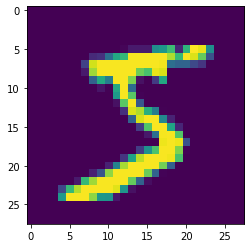

In [5]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

***Обучение глубокой сверточной нейросети***

In [6]:
class ConvModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(hidden_dim * 14 * 14, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool(x)
        x = x.view(-1, 256 * 14 * 14)
        x = self.linear1(x)
        return x


In [7]:
# Как формируется батча
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset

def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
      'target': target,
      }


In [8]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 2
batch_size = 128

In [9]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [10]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=True, 
                            collate_fn=collate_fn,
                            drop_last = True,
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')


epoch: 0, step: 0, loss: 2.3200268745422363
epoch: 0, step: 200, loss: 0.16533473134040833
epoch: 0, step: 400, loss: 0.11492106318473816
epoch: 1, step: 0, loss: 0.06106285750865936
epoch: 1, step: 200, loss: 0.03817230090498924
epoch: 1, step: 400, loss: 0.02435099519789219
epoch: 2, step: 0, loss: 0.07593771070241928
epoch: 2, step: 200, loss: 0.05463201925158501
epoch: 2, step: 400, loss: 0.09289846569299698
epoch: 3, step: 0, loss: 0.030851852148771286
epoch: 3, step: 200, loss: 0.02814987115561962
epoch: 3, step: 400, loss: 0.02074248716235161
epoch: 4, step: 0, loss: 0.053489383310079575
epoch: 4, step: 200, loss: 0.02254544012248516
epoch: 4, step: 400, loss: 0.004701006691902876


# Обучение полносвязнной сети

In [33]:
# Увидим, что показывает хороший результат, даже без Dropout и всего такого
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)

        return x

In [34]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 10
batch_size = 128

In [35]:
# Как формируется батча
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset

def collate_fn_linear(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
      'target': target,
      }



In [36]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [37]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=True, 
                            collate_fn=collate_fn,
                            drop_last = True,
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')



epoch: 0, step: 0, loss: 2.3092708587646484
epoch: 0, step: 200, loss: 0.34975531697273254
epoch: 0, step: 400, loss: 0.199563130736351
epoch: 1, step: 0, loss: 0.27012795209884644
epoch: 1, step: 200, loss: 0.06870656460523605
epoch: 1, step: 400, loss: 0.07494619488716125
epoch: 2, step: 0, loss: 0.13462935388088226
epoch: 2, step: 200, loss: 0.13760976493358612
epoch: 2, step: 400, loss: 0.1565571278333664
epoch: 3, step: 0, loss: 0.10299228131771088
epoch: 3, step: 200, loss: 0.1439799815416336
epoch: 3, step: 400, loss: 0.10603908449411392
epoch: 4, step: 0, loss: 0.09989313781261444
epoch: 4, step: 200, loss: 0.06255807727575302
epoch: 4, step: 400, loss: 0.03837882727384567
epoch: 5, step: 0, loss: 0.049151260405778885
epoch: 5, step: 200, loss: 0.1075102686882019
epoch: 5, step: 400, loss: 0.10109971463680267
epoch: 6, step: 0, loss: 0.011166566051542759
epoch: 6, step: 200, loss: 0.02611146681010723
epoch: 6, step: 400, loss: 0.034713324159383774
epoch: 7, step: 0, loss: 0.029